# Première implementation des modèles

Ce notebook est fait pour faire des tests sur l'implémentation des modèles, de la génération des données, des graphiques, etc.

In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from smc_movement_models.models import estimate_a1_a2_on_window, run_smc
from smc_movement_models.plots import plot_graph_values, plot_real_data

np.random.seed(42)

In [ ]:
gv_fig = plot_graph_values(figsize=None)

In [ ]:
day_fig = plot_real_data("../data/19_01_2008.csv", figsize=(10, 5))

In [4]:
summary = pd.read_csv("../data/summary.csv")

In [5]:
summary

,Min_Time,Max_Time,Calib_Depth_NaNs,Orig_Depth_NaNs,Velocity_NaNs,Observations
0,2008-01-14 08:37:15,2008-01-14 23:59:55,570,570,0,11073
1,2008-01-15 00:00:00,2008-01-15 23:59:55,994,994,0,17280
2,2008-01-16 00:00:00,2008-01-16 23:59:55,1321,1321,0,17280
3,2008-01-17 00:00:00,2008-01-17 23:59:55,1046,1046,0,17280
4,2008-01-18 00:00:00,2008-01-18 23:59:55,866,866,0,17280
5,2008-01-19 00:00:00,2008-01-19 23:59:55,3638,3638,0,17280
6,2008-01-20 00:00:00,2008-01-20 23:59:55,17280,17280,0,17280
7,2008-01-21 00:00:00,2008-01-21 23:59:55,17280,17280,0,17280
8,2008-01-22 00:00:00,2008-01-22 23:59:55,17280,17280,0,17280
9,2008-01-23 00:00:00,2008-01-23 23:59:55,4823,4823,0,17280


In [11]:
df = pd.read_csv("../data/clean_data.csv")

In [143]:
# day_str = "26/01/2008"
day_str_min = "15/01/2008"
day_str_max = "15/01/2008"
mask_day = (df["Date"] >= day_str_min) & (df["Date"] <= day_str_max)
day = df.loc[mask_day, ["Dtime", "Velocity", "Depth"]]
day["Dtime"] = pd.to_datetime(day["Dtime"])

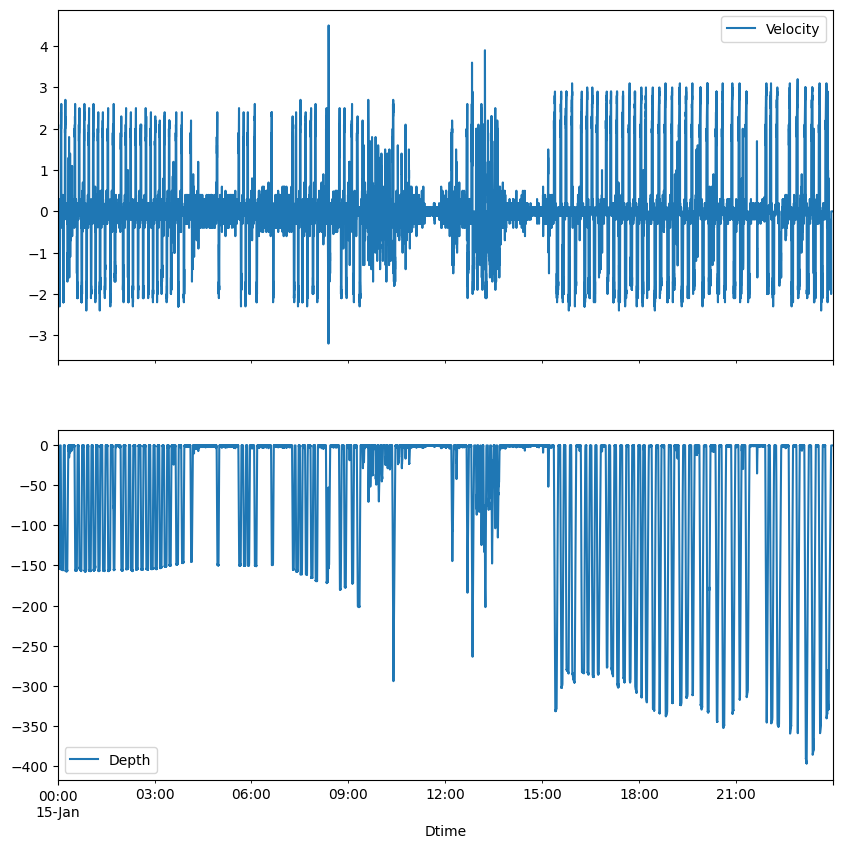

In [144]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

day.plot(x="Dtime", y="Velocity", ax=ax1)
day.plot(x="Dtime", y="Depth", ax=ax2);

In [145]:
window_size = 312
overlap_size = int(window_size / 2)
num_windows = int((len(day) - overlap_size) / overlap_size)

windows = []
ids = []
for i in range(num_windows):
    window = day[i * overlap_size : (i + 2) * overlap_size - 1]["Velocity"].values
    ids.append((i + 1) * overlap_size)
    windows.append(window)

In [27]:
final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5)

In [146]:
time_a1s = []
time_a2s = []

for window in tqdm(windows):
    final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5)
    time_a1s.append(final_a1s)
    time_a2s.append(final_a2s)

time_a1s = np.array(time_a1s)
time_a2s = np.array(time_a2s)
time_results = pd.DataFrame(
    {
        "Dtime": day["Dtime"].iloc[ids],
        "a1s": time_a1s[:, -1].mean(axis=1),
        "a2s": time_a2s[:, -1].mean(axis=1),
    }
)

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]


In [147]:
time_results["rolling_a1s"] = time_results["a1s"].rolling(window=5, center=True).mean()
time_results["rolling_a2s"] = time_results["a2s"].rolling(window=5, center=True).mean()

C:\Users\gabri\AppData\Local\Temp\ipykernel_4032\1584991118.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


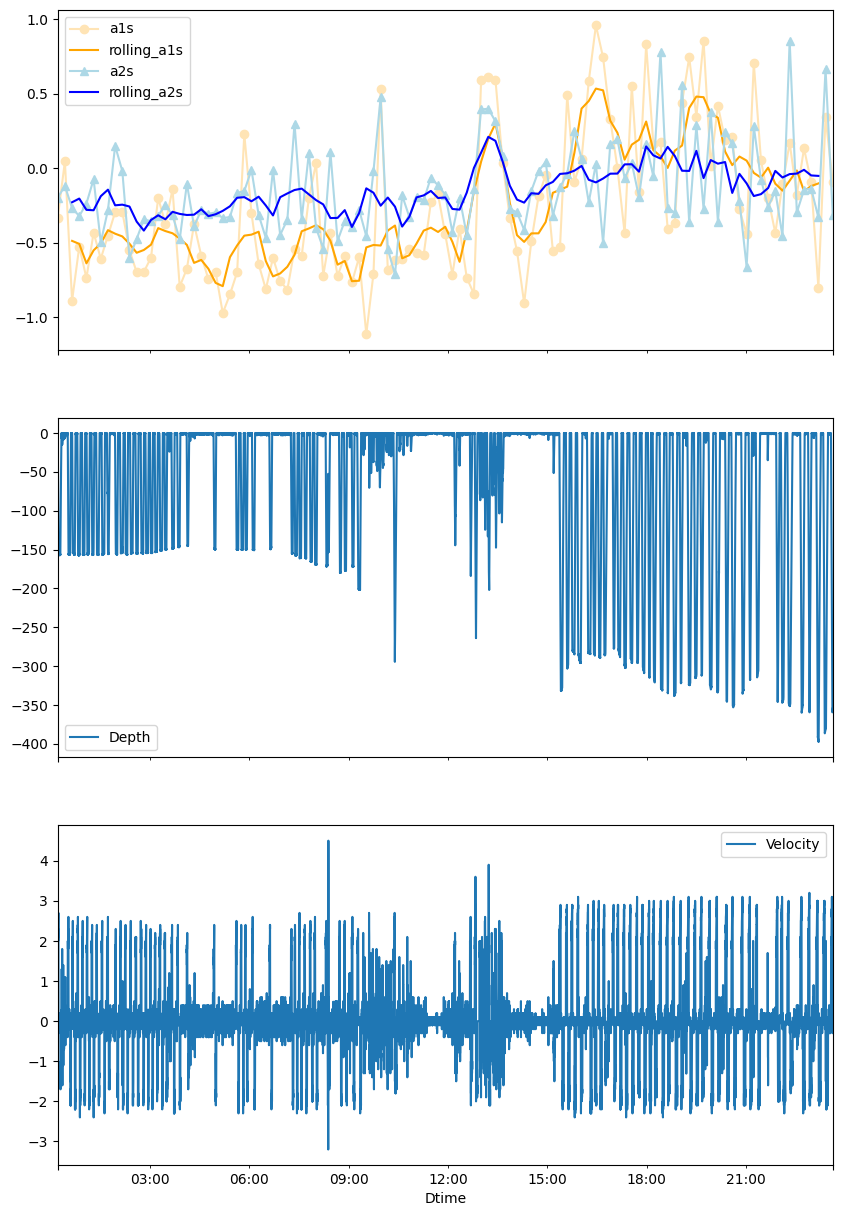

In [148]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

day.plot(x="Dtime", y="Velocity", ax=axs[2])
day.plot(x="Dtime", y="Depth", ax=axs[1])
time_results.plot(x="Dtime", y="a1s", ax=axs[0], marker="o", color="moccasin")
time_results.plot(x="Dtime", y="rolling_a1s", ax=axs[0], color="orange")
time_results.plot(x="Dtime", y="a2s", ax=axs[0], marker="^", color="lightblue")
time_results.plot(x="Dtime", y="rolling_a2s", ax=axs[0], color="blue")
fig.show()

In [31]:
last_a1s = []
last_a2s = []
for i in tqdm(range(100)):
    final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5)
    last_a1s.append(final_a1s.mean(axis=1)[-1])
    last_a2s.append(final_a2s.mean(axis=1)[-1])

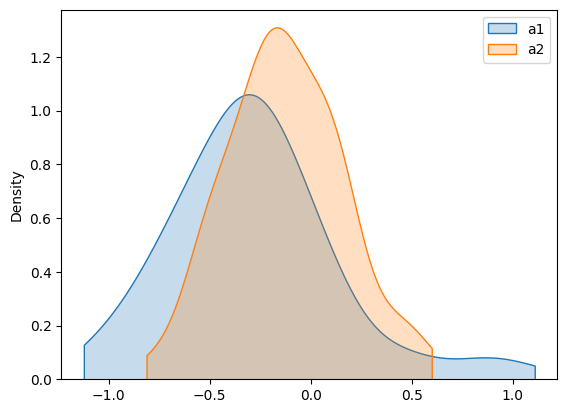

In [34]:
sns.kdeplot(last_a1s, fill=True, label="a1", cut=0)
sns.kdeplot(last_a2s, fill=True, label="a2", cut=0)
plt.legend()

In [30]:
final_a1s.mean(axis=1)

array([-0.32393425, -0.00547199, -0.09965049,  0.05268628,  0.07978089,
        0.02424021,  0.01255839,  0.00214959,  0.00403476,  0.00643152])

In [ ]:
epsilon = 0.1
final_a1s = []
final_a2s = []
for m in range(10):
    a1 = final_a1s[-1].mean() if m > 0 else 0
    a2 = final_a2s[-1].mean() if m > 0 else 0
    alg = run_smc(window=window, sigma_v=epsilon, a1=a1, a2=a2)
    a1s_tmp = np.array(alg.hist.X)[:, :, 2]
    a2s_tmp = np.array(alg.hist.X)[:, :, 3]
    wgts = np.array([w.W for w in alg.hist.wgts])
    final_a1s.append(np.average(a1s_tmp, weights=wgts, axis=1))
    final_a2s.append(np.average(a2s_tmp, weights=wgts, axis=1))
    epsilon *= 0.5

final_a1s = np.array(final_a1s)
final_a2s = np.array(final_a2s)
a1s = final_a1s.mean(axis=1)
a2s = final_a2s.mean(axis=1)

In [ ]:
print(a1s, a2s)

In [ ]:
for i in range(10):
    sns.kdeplot(np.array(final_a1s)[i, :], fill=True, label=f"iter {i+1}")

plt.legend()

In [ ]:
my_alg = run_smc(window, N=200)

In [ ]:
a1s_tmp = np.array(alg.hist.X)[:, :, 2]
a2s_tmp = np.array(alg.hist.X)[:, :, 3]
wgts = np.array([w.W for w in alg.hist.wgts])
a1s = np.average(a1s_tmp, weights=wgts, axis=1)
a2s = np.average(a2s_tmp, weights=wgts, axis=1)

In [ ]:
sns.kdeplot(a1s, fill=True, label="a1")
sns.kdeplot(a2s, fill=True, label="a2")
plt.legend()

In [ ]:
x_range = np.arange(len(window))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(x_range, a1s)
axs[1].plot(x_range, a2s)